In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import torch
import itertools
from torch import nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

The data used for this project come from: https://archive.ics.uci.edu/dataset/242/energy+efficiency

### 1. Loading data.  


Renaming columns because the features were called X1–X8 and the labels were called Y1 and Y2. Column names must be descriptive, without spaces, and clearly distinguish features from labels.

In [2]:
cols = ["relative_compactness", "surface_area", "wall_area", "roof_area", "overall_height", "orientation", "glazing_area",   
        "glazing_area_distribution", "heating_load", "cooling_load"]
dataset = pd.read_excel("energy_efficient.xlsx", names=cols)
dataset

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


**1.1 Converting Data into a Classification Problem**

In this Jupyter notebook, we will analyze a classification problem, so we need to convert the regression data into a classification problem using the median as the threshold.

In [3]:
threshold_heating = dataset["heating_load"].median() 
dataset["heating_load"] = (dataset["heating_load"] <= threshold_heating).astype(int)
threshold_cooling = dataset["cooling_load"].median()
dataset["cooling_load"] = (dataset["cooling_load"] <= threshold_cooling).astype(int)

**1.2 Understanding the data**

In [4]:
dataset_heating = dataset.iloc[:, :-1]
dataset_heating.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,1
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,1
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,1
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,1
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,0


The dataset consists of eight features and one target variable. Six features are numerical, while the remaining two are categorical and ordinal (orientation and glazing_area_distribution).

In [5]:
dataset_heating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    int64  
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    int64  
 8   heating_load               768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


The dataset contains 768 entries with no missing values.

In [6]:
dataset_heating.describe()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,0.500000
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,0.500326
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,0.000000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,0.000000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,0.500000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,1.000000
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,1.000000


From the initial inspection using the describe() method, no significant outliers are observed, as the minimum and maximum values do not deviate substantially from the rest of the data. The columns relative_compactness, surface_area, wall_area, roof_area, overall_height, and glazing_area are numerical features with values outside the range [0, 1]. Therefore, feature scaling is required to improve the performance and convergence of machine learning algorithms. Additionally, a few features exhibit mild skewness; however, the skewness is minimal and does not indicate severe distribution imbalance.

**1.3 Data Visualization**

**1.3.1 Label - heating load**

In [52]:
dataset_heating["heating_load"].value_counts()

heating_load
1    384
0    384
Name: count, dtype: int64

In [7]:
sns.set_theme(style="whitegrid", palette="muted")

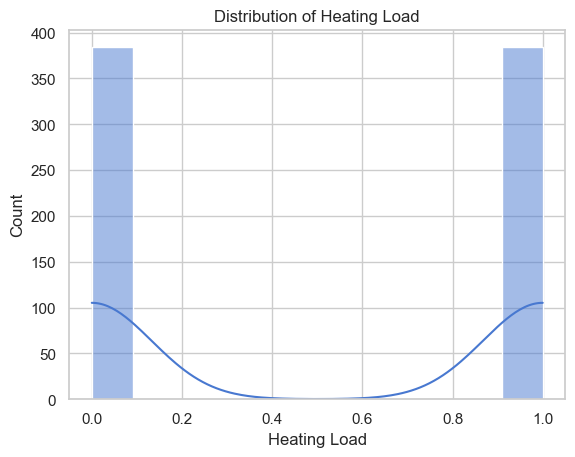

In [8]:
sns.histplot(dataset_heating["heating_load"], kde=True)
plt.title("Distribution of Heating Load")
plt.xlabel("Heating Load")
plt.show()

The target variable, heating load, contains an equal number of values for classes 0 and 1, indicating a perfectly balanced class distribution. This balanced dataset helps prevent model bias toward a particular class and supports more reliable and stable model performance.

**1.3.2 Features**

Boxplots show limited variability due to the synthetic and structured nature of the dataset.
Therefore, histplots and violin plots are used to better illustrate data distribution and feature–target relationships.

**1.3.2.1 - Realative Compactness**

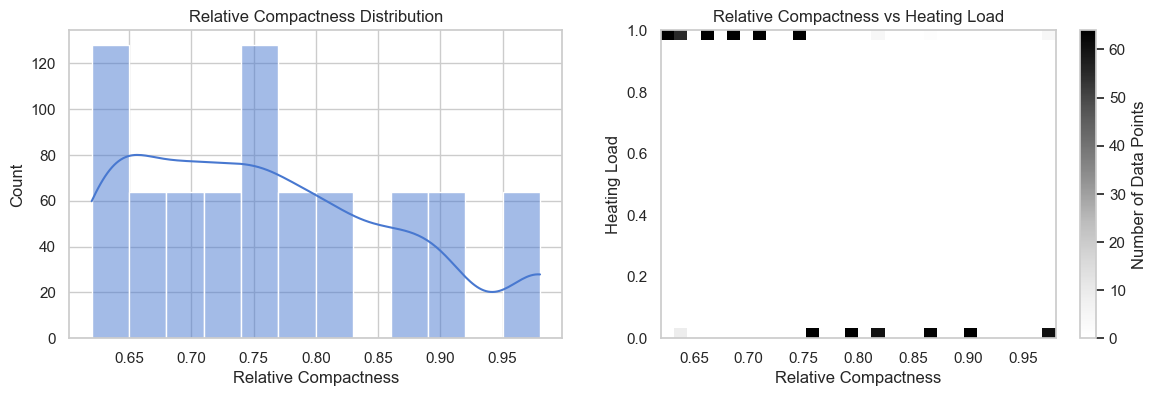

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["relative_compactness"], kde=True, ax=ax[0])
ax[0].set_title("Relative Compactness Distribution")
ax[0].set_xlabel("Relative Compactness")

h1 = ax[1].hist2d(
    x=dataset_heating["relative_compactness"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Relative Compactness")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Relative Compactness vs Heating Load")

plt.show()

**1.3.2.2 - Surface area**

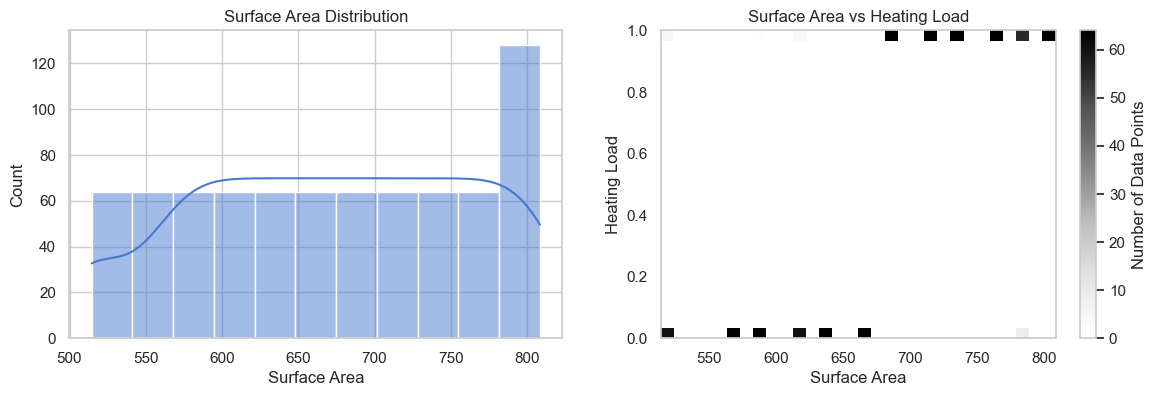

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["surface_area"], kde=True, ax=ax[0])
ax[0].set_title("Surface Area Distribution")
ax[0].set_xlabel("Surface Area")

h1 = ax[1].hist2d(
    x=dataset_heating["surface_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1])  
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Surface Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Surface Area vs Heating Load")

plt.show()

**1.3.2.3 - Wall area**

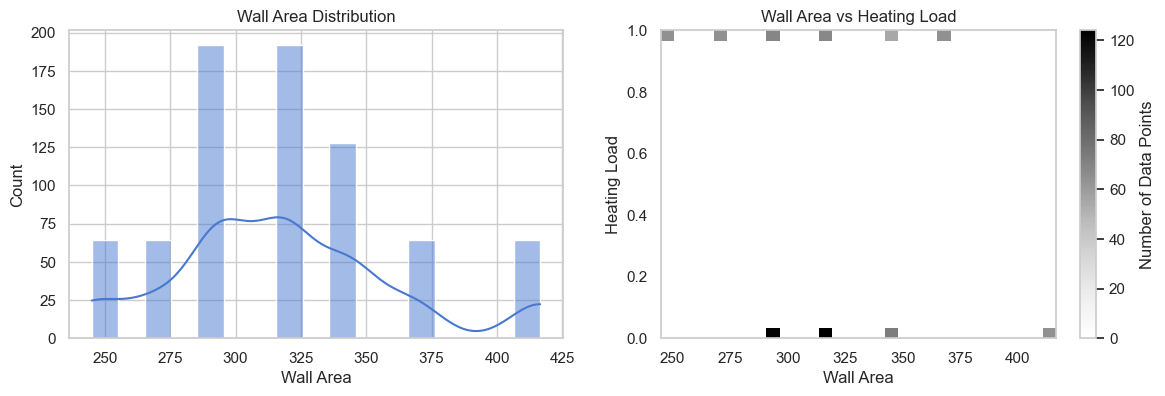

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["wall_area"], kde=True, ax=ax[0])
ax[0].set_title("Wall Area Distribution")
ax[0].set_xlabel("Wall Area")

h1 = ax[1].hist2d(
    x=dataset_heating["wall_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Wall Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Wall Area vs Heating Load")

plt.show()

**1.3.2.4 - Roof Area**

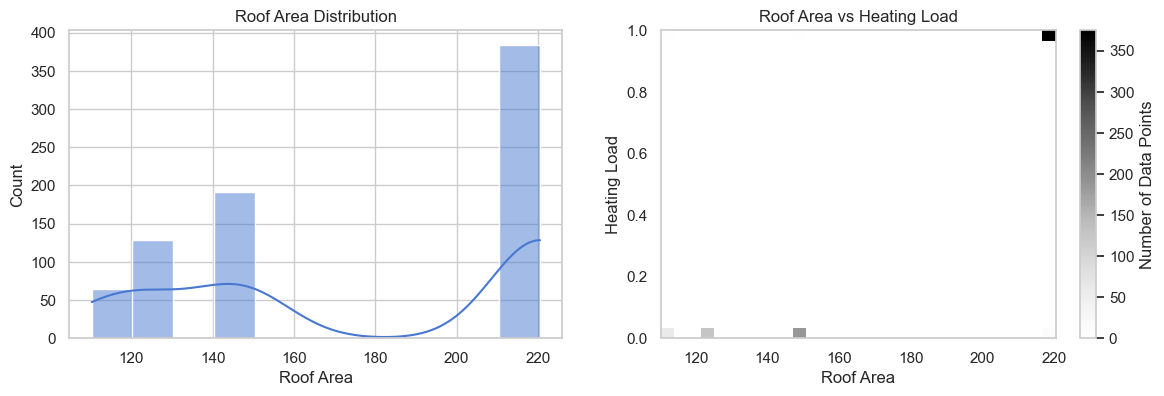

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["roof_area"], kde=True, ax=ax[0])
ax[0].set_title("Roof Area Distribution")
ax[0].set_xlabel("Roof Area")

h1 = ax[1].hist2d(
    x=dataset_heating["roof_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Roof Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Roof Area vs Heating Load")

plt.show()

**1.3.2.5 - Overall height**

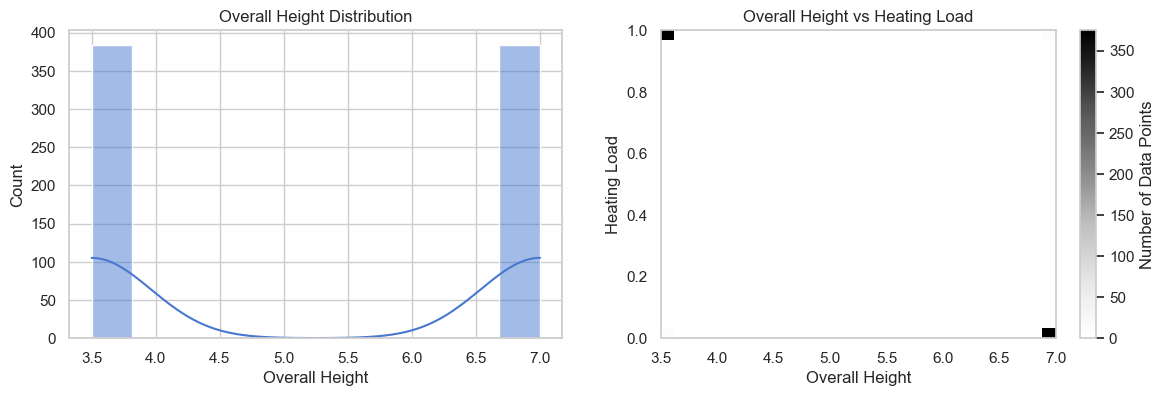

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["overall_height"], kde=True, ax=ax[0])
ax[0].set_title("Overall Height Distribution")
ax[0].set_xlabel("Overall Height")

h1 = ax[1].hist2d(
    x=dataset_heating["overall_height"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Overall Height")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Overall Height vs Heating Load")

plt.show()

**1.3.2.6 - Glaizing Area**

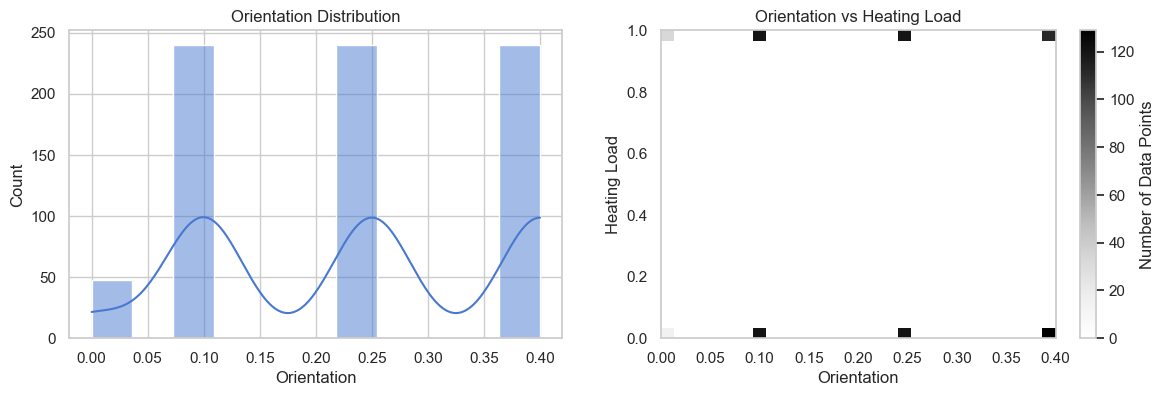

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["glazing_area"], kde=True, ax=ax[0])
ax[0].set_title("Orientation Distribution")
ax[0].set_xlabel("Orientation")

h1 = ax[1].hist2d(
    x=dataset_heating["glazing_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1])  
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Orientation")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Orientation vs Heating Load")

plt.show()

**1.3.2.7 - Orientation**

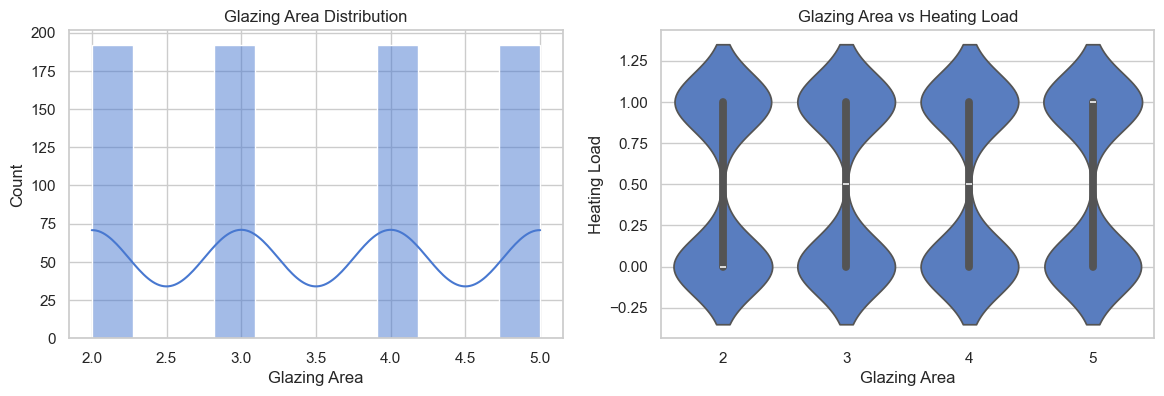

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["orientation"], kde=True, ax=ax[0])
ax[0].set_title("Glazing Area Distribution")
ax[0].set_xlabel("Glazing Area")

h1 = sns.violinplot(x="orientation", y="heating_load", data=dataset_heating, ax=ax[1])

ax[1].set_xlabel("Glazing Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Glazing Area vs Heating Load")

plt.show()

**1.3.2.8 - Glazing Area Distribution**

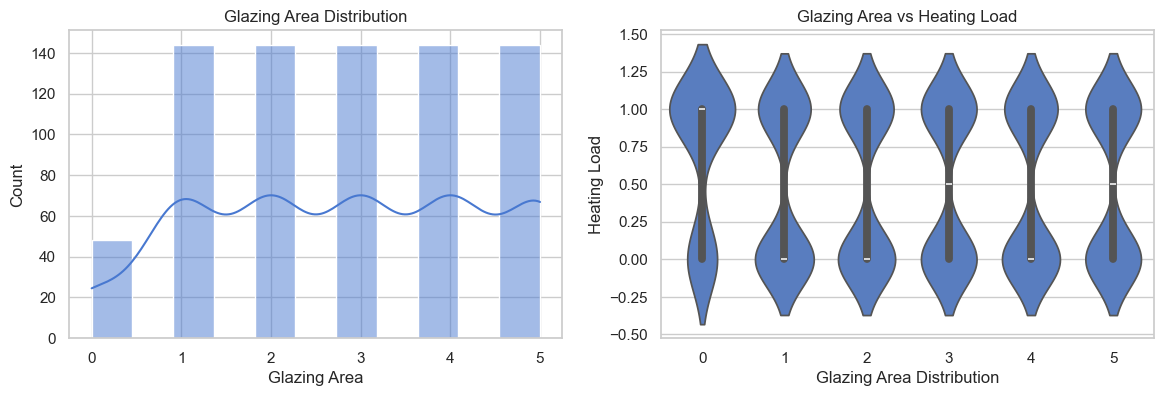

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["glazing_area_distribution"], kde=True, ax=ax[0])
ax[0].set_title("Glazing Area Distribution")
ax[0].set_xlabel("Glazing Area")

h1 = sns.violinplot(x="glazing_area_distribution", y="heating_load", data=dataset_heating, ax=ax[1])

ax[1].set_xlabel("Glazing Area Distribution")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Glazing Area vs Heating Load")

plt.show()

**1.3.3 - Correlaction Matrix**

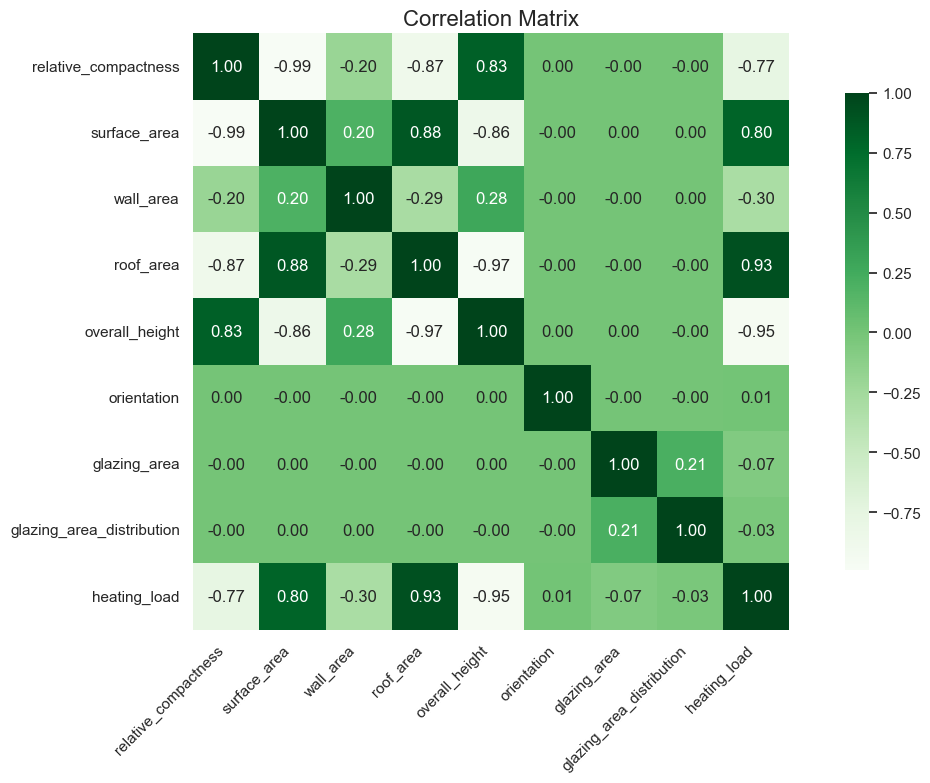

In [17]:
plt.figure(figsize=(12, 8)) 

sns.heatmap(
    dataset_heating.corr(numeric_only=True),
    cmap="Greens",
    annot=True,
    fmt=".2f",       
    square=True,      
    cbar_kws={"shrink": 0.8} 
)

plt.title("Correlation Matrix", fontsize=16) 
plt.xticks(rotation=45, ha="right")           
plt.yticks(rotation=0)                        
plt.tight_layout()
plt.show()

As shown in the above matrix, the strongest correlations between the features and the target variable are:
- overall height: 95%
- roof area: 93%
- surface area: 80%
- relative compactness: 77%

The columns overall height and relative compactness show negative correlation values, indicating an inverse relationship with the target variable.

The 

### 2. Data cleaning

**2.1 Check and remove duplicates**

In [18]:
dataset_heating.duplicated().sum()

np.int64(0)

There is no duplicate data.

**2.2 Detect missing values**

In [19]:
dataset_heating.isnull().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
dtype: int64

There are also no missing values.

In [20]:
dataset_heating.nunique()

relative_compactness         12
surface_area                 12
wall_area                     7
roof_area                     4
overall_height                2
orientation                   4
glazing_area                  4
glazing_area_distribution     6
heating_load                  2
dtype: int64

Don't need to correcting: validation, handling dates and times, handling outliers, correcting datatypes or dropping irrelavant columns.

**2.3 Feature Engineering**

**2.3.1 Scaling**

The dataset contains eight numeric columns with values outside the 0–1 range. To improve model training and prediction accuracy, we scale these features using StandardScaler, which standardizes each feature by removing the mean and scaling to unit variance. This ensures the features are centered around 0 with a standard deviation of 1, which benefits many machine learning algorithms, especially those sensitive to feature magnitude.

In [21]:
scaler = StandardScaler()

In [22]:
columns_scaled = ["relative_compactness", "surface_area", "wall_area", "roof_area", "overall_height", "glazing_area"]
dataset_scaled = dataset_heating[columns_scaled]

In [23]:
dataset_scaled

,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area
0,0.98,514.5,294.0,110.25,7.0,0.0
1,0.98,514.5,294.0,110.25,7.0,0.0
2,0.98,514.5,294.0,110.25,7.0,0.0
3,0.98,514.5,294.0,110.25,7.0,0.0
4,0.90,563.5,318.5,122.50,7.0,0.0
...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,0.4
764,0.62,808.5,367.5,220.50,3.5,0.4
765,0.62,808.5,367.5,220.50,3.5,0.4
766,0.62,808.5,367.5,220.50,3.5,0.4


In [24]:
scaled_values = scaler.fit_transform(dataset_scaled)
dataset_scal = pd.DataFrame(scaled_values, columns=dataset_scaled.columns)
dataset_scal

,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area
0,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
2,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
3,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
4,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447
...,...,...,...,...,...,...
763,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049
764,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
765,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
766,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049


In [25]:
dataset_heating = dataset_heating.drop(columns_scaled, axis=1)
dataset_heating = pd.concat([dataset_heating, dataset_scal], axis=1)

In [26]:
dataset_heating

,orientation,glazing_area_distribution,heating_load,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area
0,2,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
1,3,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
2,4,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
3,5,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
4,2,0,0,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447
...,...,...,...,...,...,...,...,...,...
763,5,5,1,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049
764,2,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
765,3,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
766,4,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049


**2.3.2 One-hot encoding**

The dataset contains two ordinal categorical columns. During preprocessing, these columns will be transformed using one-hot encoding to convert them into a numerical format suitable for machine learning models.

In [27]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
orientation_encoded = ohe.fit_transform(dataset_heating[['orientation']])
orientation_cols = ohe.get_feature_names_out(['orientation'])
orientation_dataset = pd.DataFrame(orientation_encoded, columns=orientation_cols, index=dataset_heating.index)

In [28]:
dataset_heating = dataset_heating.drop('orientation', axis=1)
dataset_heating = pd.concat([dataset_heating, orientation_dataset], axis=1)

In [29]:
dataset_heating

,glazing_area_distribution,heating_load,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area,orientation_2,orientation_3,orientation_4,orientation_5
0,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,1.0,0.0,0.0,0.0
1,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,1.0,0.0,0.0
2,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,1.0,0.0
3,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,0.0,1.0
4,0,0,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
763,5,1,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049,0.0,0.0,0.0,1.0
764,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,1.0,0.0,0.0,0.0
765,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,1.0,0.0,0.0
766,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,0.0,1.0,0.0


In [30]:
glazing_area_distribution_encoded = ohe.fit_transform(dataset_heating[['glazing_area_distribution']])
glazing_area_distribution_cols = ohe.get_feature_names_out(['glazing_area_distribution'])
glazing_area_distribution_dataset = pd.DataFrame(glazing_area_distribution_encoded, columns=glazing_area_distribution_cols, index=dataset_heating.index)

In [31]:
dataset_heating = dataset_heating.drop('glazing_area_distribution', axis=1)
dataset_heating = pd.concat([dataset_heating, glazing_area_distribution_dataset], axis=1)

In [32]:
dataset_heating

,heating_load,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area,orientation_2,orientation_3,orientation_4,orientation_5,glazing_area_distribution_0,glazing_area_distribution_1,glazing_area_distribution_2,glazing_area_distribution_3,glazing_area_distribution_4,glazing_area_distribution_5
0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
764,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
765,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
766,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3. Spliting dataset

The dataset will be split into training and testing sets in an 80:20 ratio, where 80% of the data is used for training the model and 20% is reserved for evaluating its performance on unseen data.

In [33]:
X = dataset_heating.iloc[:, 1:]
y_heating = dataset["heating_load"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_heating, test_size=0.2, random_state=42)

In [35]:
len(X_train), len(X_test), len(y_train), len(y_test)

(614, 154, 614, 154)

### 4. Model Selection (Classification)

For a **classification problem**, model selection involves choosing algorithms that can accurately assign data points to predefined classes.  

**Key considerations include:**

- **Algorithm suitability:** Choosing models that handle the dataset’s characteristics, such as the number of features, feature correlations, and class balance.  
- **Performance evaluation:** Comparing models using metrics like **accuracy, precision, recall, F1-score,** and **ROC-AUC** on validation data.  
- **Complexity vs. interpretability:** Balancing model accuracy with ease of interpretation (e.g., decision trees are more interpretable than ensemble methods).  
- **Computational efficiency:** Considering training and prediction time, especially for large datasets.  

**Common classification models to consider:**

| Model | Description |
|-------|-------------|
| **Logistic Regression** | Simple and interpretable, ideal for binary classification. |
| **Decision Trees** | Handle non-linear relationships and categorical features well. |
| **Random Forest / Gradient Boosting** | Ensemble methods that improve accuracy and reduce overfitting. |
| **Support Vector Machines (SVM)** | Effective for high-dimensional data. |
| **k-Nearest Neighbors (k-NN)** | Simple distance-based classification. |


In [36]:
def plot_confusion_matrix(y_test, y_pred, model):
    sns.set_theme(style="white")
    figsize = (10, 10)

    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[: np.newaxis]
    n_classes = cm.shape[0]

    fig , ax = plt.subplots(figsize=figsize)

    cax = ax.matshow(cm, cmap = plt.cm.Blues)
    fig.colorbar(cax)
    classes = False
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title = f"Confusion Matrix ({model})", xlabel="Predicted Label", ylabel = "True Label", xticks=np.arange(n_classes), yticks= np.arange(n_classes), xticklabels = labels, yticklabels = labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.title.set_size(20)

    threshold = (cm.max() + cm.min()) / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)", horizontalalignment = "center", color="white" if cm[i, j] > threshold else "black", size=15)

**4.1 Algorithm: Logistic Regression**

In [37]:
lg_model_heat = LogisticRegression()
lg_model_heat.fit(X_train, y_train)
y_pred_lg_heat = lg_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_lg_heat))

acc_log = round(lg_model_heat.score(X_train, y_train) * 100, 2)
acc_log

              precision    recall  f1-score   support

           0       0.99      0.96      0.98        83
           1       0.96      0.99      0.97        71

    accuracy                           0.97       154
   macro avg       0.97      0.97      0.97       154
weighted avg       0.97      0.97      0.97       154



97.56

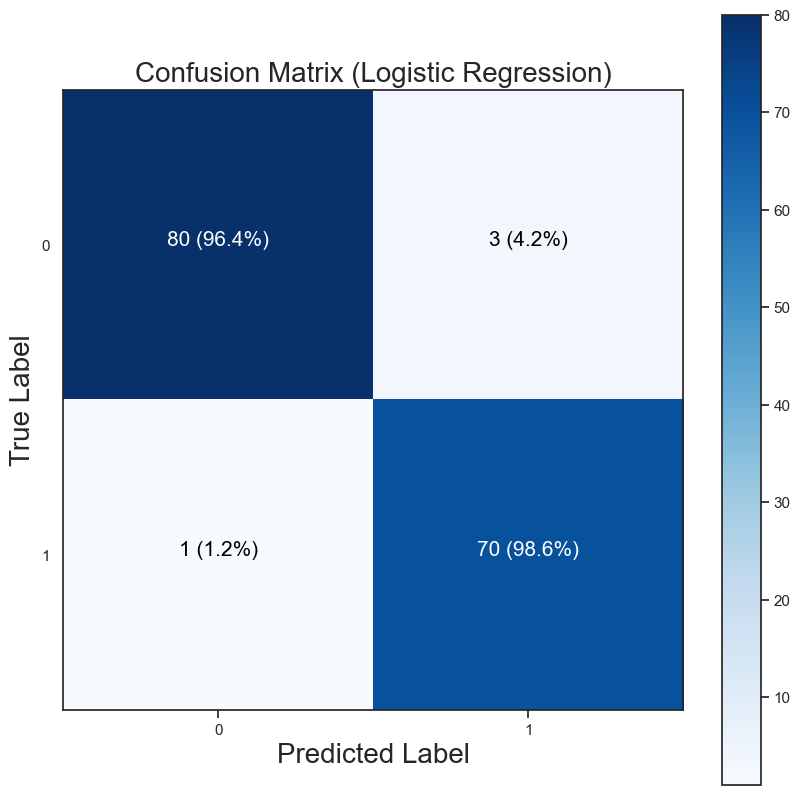

In [38]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred_lg_heat, model="Logistic Regression")

**4.2 Algorithm: K-Nearest Neighbors (KNN)!**

In [39]:
knn_model_heat = KNeighborsClassifier(n_neighbors=5)
knn_model_heat.fit(X_train, y_train)
y_pred_knn_heat = knn_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_knn_heat))

acc_knn = round(knn_model_heat.score(X_train, y_train) * 100, 2)
acc_knn

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        83
           1       0.96      1.00      0.98        71

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



98.37

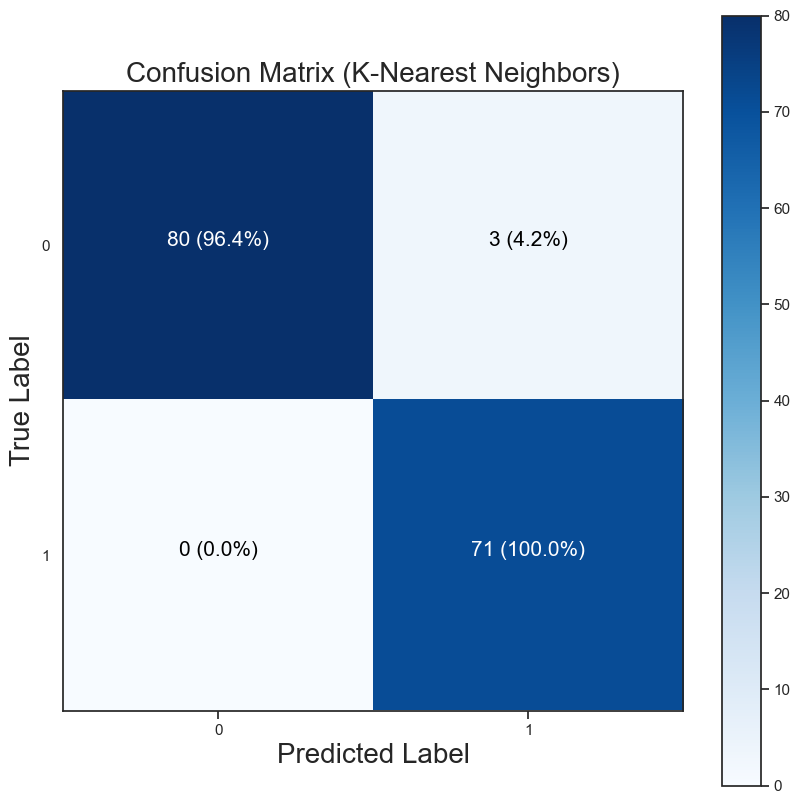

In [40]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred_knn_heat, model="K-Nearest Neighbors")

**4.3 Algorithm: Naive Bayes (NB)!**

In [41]:
nb_model_heat = GaussianNB()
nb_model_heat.fit(X_train, y_train)
y_pred_nb_heat = nb_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_nb_heat))

acc_nb = round(nb_model_heat.score(X_train, y_train) * 100, 2)
acc_nb

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        83
           1       0.97      0.99      0.98        71

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



97.56

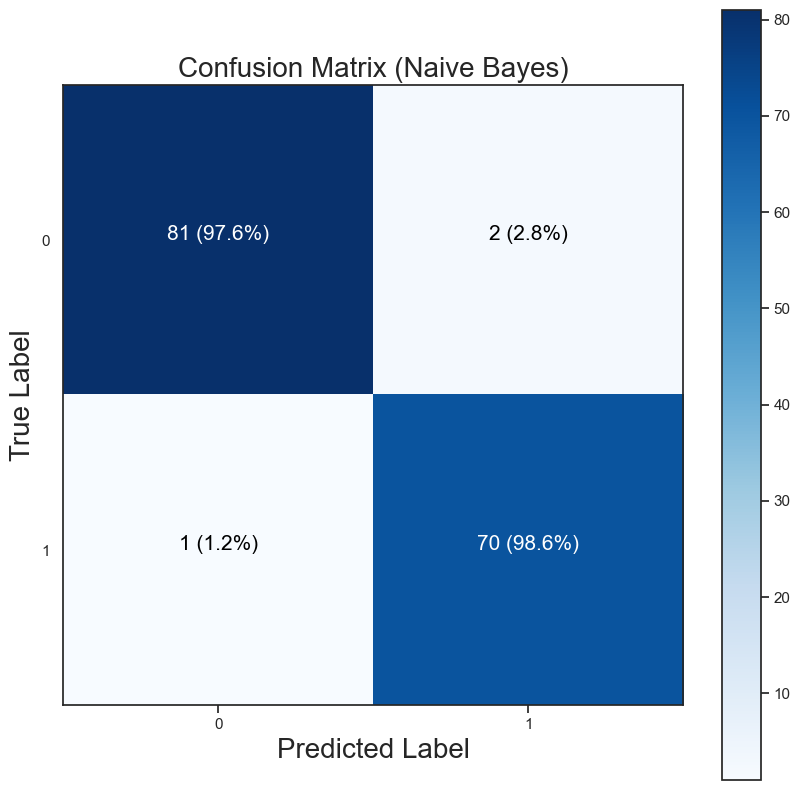

In [42]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred_nb_heat, model="Naive Bayes")

**4.4 Algorithm: Decision Tree**

In [43]:
dt_model_heat = DecisionTreeClassifier()
dt_model_heat.fit(X_train, y_train)
y_pred_dt_heat = dt_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_dt_heat))

acc_dt = round(dt_model_heat.score(X_train, y_train) * 100, 2)
acc_dt

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        83
           1       0.97      0.99      0.98        71

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



100.0

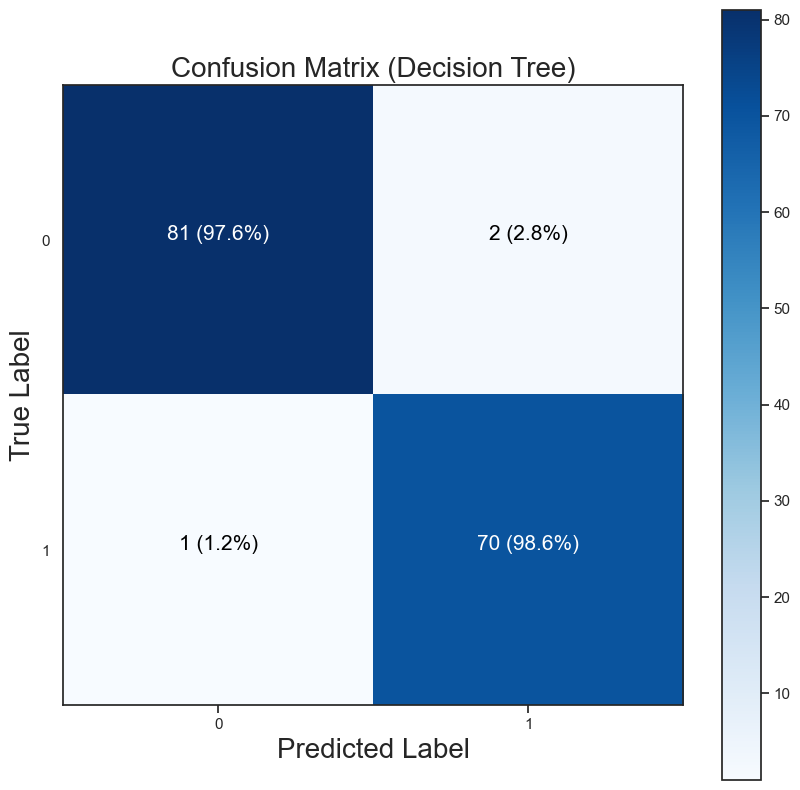

In [44]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred_dt_heat, model="Decision Tree")

**4.5 Deep Learning with Pytorch!**

In [45]:
X_train_nn= torch.from_numpy(X_train.values).type(torch.float32)
y_train_nn = torch.from_numpy(y_train.values).type(torch.float32)
X_test_nn= torch.from_numpy(X_test.values).type(torch.float32)
y_test_nn = torch.from_numpy(y_test.values).type(torch.float32)

In [46]:
model_nn = nn.Sequential(
    nn.Linear(in_features=16, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
)

In [47]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_nn.parameters(), lr=0.01)

In [48]:
def accurancy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

In [49]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_nn.train()

    y_logits = model_nn(X_train_nn).squeeze()
    y_pred_nn = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train_nn)
    acc = accurancy_fn(y_true=y_train_nn, y_pred=y_pred_nn)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    model_nn.eval()
    with torch.inference_mode():
        test_logits = model_nn(X_test_nn).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test_nn)
        test_acc = accurancy_fn(y_true = y_test_nn, y_pred = test_pred)

    # if epoch % 10 == 0:
        # print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc: 2f}")

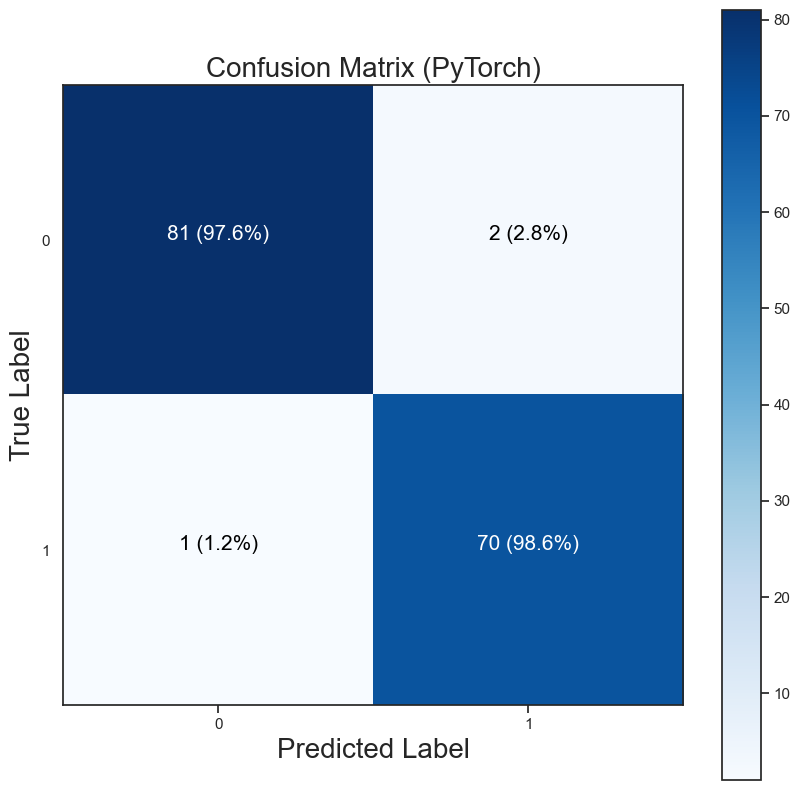

In [50]:
plot_confusion_matrix(y_test=y_test, y_pred=test_pred, model="PyTorch")

### 5. Model Comparison

In [51]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 'Decision Tree', "TensorFlow"],
    'Score': [ acc_knn, acc_log, acc_nb, acc_dt, test_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Decision Tree,100.000000
0,KNN,98.370000
4,TensorFlow,98.051948
2,Naive Bayes,97.560000
1,Logistic Regression,97.560000
